# 02.21.05 - DNN MFCC20 (4-Fold, upsampled minority, data augmented) SIGMOID


## Prerequisites

- The dataset exists (if not, execute 02.00.01
- The dataset features have been populated (if not, execute 02.00.02)

## Goals

In this experiment, we intend to assess the generalization capability of a Dense Neural Network using MFCC coeffecicients as features, through a 4-folds cross validation over the hive axis.

In hope to improve generalization performance, we introduce data augmentation in the feature space, by adding samples where feature rows are "scratched", i.e overwritten either with a fixed value (usually 0) or the mean of the feature cells (here we use the mean).

Our MFCC feature having 20 coefficients, this results in a dataset size 21 times as big as the intial one (original samples + scratched ones along each coefficient).

Additionnaly, to mitigate data unbalance, for each fold we randomly upsample the under-represented class in order to reach the same cardinality as the majority class.

*Note: In reality, due to the fact that some hives in the reference dataset only present one label value (either queen of noqueen) a fold may be an agregate of 2 distincts hives, but in any case, for each fold, the network is tested over samples belonging to hive(s) it was never trained on.*

Distribution details are provided below:

<table border="1" class="dataframe" align="left">
  <thead>
    <tr style="text-align: right;">
      <th></th>
      <th>fold</th>
      <th>hive</th>
      <th>queen</th>
      <th>count(*)</th>
    </tr>
  </thead>
  <tbody>
    <tr>
      <th>0</th>
      <td>1</td>
      <td>CF001</td>
      <td>0.0</td>
      <td>14</td>
    </tr>
    <tr>
      <th>1</th>
      <td>1</td>
      <td>CF003</td>
      <td>1.0</td>
      <td>3649</td>
    </tr>
    <tr>
      <th>2</th>
      <td>2</td>
      <td>CJ001</td>
      <td>0.0</td>
      <td>790</td>
    </tr>
    <tr>
      <th>3</th>
      <td>2</td>
      <td>GH001</td>
      <td>1.0</td>
      <td>1396</td>
    </tr>
    <tr>
      <th>4</th>
      <td>3</td>
      <td>Hive1</td>
      <td>0.0</td>
      <td>1473</td>
    </tr>
    <tr>
      <th>5</th>
      <td>3</td>
      <td>Hive1</td>
      <td>1.0</td>
      <td>2684</td>
    </tr>
    <tr>
      <th>6</th>
      <td>4</td>
      <td>Hive3</td>
      <td>0.0</td>
      <td>6545</td>
    </tr>
    <tr>
      <th>7</th>
      <td>4</td>
      <td>Hive3</td>
      <td>1.0</td>
      <td>654</td>
    </tr>
  </tbody>
</table>
<br><br><br><br><br><br><br><br><br><br><br><br><br>


## Conclusion
TODO (DID NOT RUN)




<hr style="border:1px solid gray"></hr>

### Step 1: Get previously created dataset

In [1]:
import warnings                      # This block prevents display of harmless warnings, but should be
warnings.filterwarnings('ignore')    # commented out till the experiment final version,
                                     # in order to avoid missing "real" warnings 

import kilroy_was_here               # Mandatory. Allow access to shared python code from repository root
from audace.jupytools import (
    iprint,                          # timestamped (to the ms) print with CPU and RAM consumption information  
    predestination,                  # Seeds various PRNGs for reproducibility
    say_my_name                      # gets notebook name
)

from audace.audiodataset import AudioDataset      # Main class for audio dataset handling

from IPython.display import display

#########################
# Experiment parameters #
#########################

EXP_NAME = say_my_name()  # Experiment name will be used to create outputs directory

DATASET_NAME = 'MAIN1000' # Dataset name is the master key for dataset addressing
                          # Change it according to the dataset you want to process

FEATURE_NAME = 'mfcc20'   # Name of the feature used for classification
LABEL_NAME = 'queen'      # Name of the label used for classification
FOLD_NAME = 'fold'        # Column nam of the fold axis
VALID_FRAC = 0.3          # Fraction of the training set used for validation (NOT TESTING)
                          # This is used to drive early stopping. Hyperparameters may be tuned
                          # over the validation set, but the test set is kept isolated to avoid biases.


# Initialize Dataset Object. 
ds = AudioDataset(DATASET_NAME)
    
# Display AudioDataset summary    
ds.info()

# Build dataframe containing all the information needed to conduct the experiment
sql = F"SELECT {FEATURE_NAME}, {LABEL_NAME}, {FOLD_NAME} FROM samples WHERE nobee = 0"
df = ds.queryDataFrame(sql)

# Display detailed cardinalities
print("\n====== CARDINALITIES ======")
sql = """
    select distinct fold, hive, queen, count(*)
    from samples
    where nobee = 0
    group by fold, queen
    order by fold, queen
    """
display(ds.queryDataFrame(sql))

# display distribution per fold
print("\n======  PER FOLD QUEEN/NOQUEEN DISTRIBUTION ======")
sql = """
    select distinct fold,
    count(case queen when 1.0 then 1 else null end) as Q,
    count(case queen when 0.0 then 1 else null end) as NQ,
    round(100.0*count(case queen when 1.0 then 1 else null end)/count(*), 2)  as Q_ratio
    from samples
    where nobee = 0
    group by fold
    order by fold
    """
display(ds.queryDataFrame(sql))


# display global distribution
print("\n======  GLOBAL QUEEN/NOQUEEN DISTRIBUTION ======")
sql = """
    select
    count(case queen when 1.0 then 1 else null end) as Q,
    count(case queen when 0.0 then 1 else null end) as NQ,
    round(100.0*count(case queen when 1.0 then 1 else null end)/count(*), 2)  as Q_ratio
    from samples
    where nobee = 0
    """
display(ds.queryDataFrame(sql))

[2020-09-09/19:09:04.395|42.5%|65.7%|0.28GB] ------------------------------------------------------
[2020-09-09/19:09:04.395|00.0%|65.7%|0.28GB] DATASET NAME          : MAIN1000
[2020-09-09/19:09:04.396|87.5%|65.7%|0.28GB] DATASET PATH          : D:\Jupyter\ShowBees\datasets\MAIN1000
[2020-09-09/19:09:04.396|00.0%|65.7%|0.28GB] DATASET DB PATH       : D:\Jupyter\ShowBees\datasets\MAIN1000\MAIN1000.db
[2020-09-09/19:09:04.396|00.0%|65.7%|0.28GB] DATASET SAMPLES PATH  : D:\Jupyter\ShowBees\datasets\MAIN1000\samples
[2020-09-09/19:09:04.396|00.0%|65.7%|0.28GB] NB SOURCE AUDIO FILES : 48
[2020-09-09/19:09:04.397|00.0%|65.7%|0.28GB] SAMPLE RATE           : 22050
[2020-09-09/19:09:04.397|00.0%|65.7%|0.28GB] DURATION              : 1.0
[2020-09-09/19:09:04.397|00.0%|65.7%|0.28GB] OVERLAP               : 0.0
[2020-09-09/19:09:04.397|00.0%|65.7%|0.28GB] NB AUDIO CHUNKS       : 24788
[2020-09-09/19:09:04.398|00.0%|65.7%|0.28GB] ------------------------------------------------------

====== CARDI

,fold,hive,queen,count(*)
0,1,CF001,0.0,14
1,1,CF003,1.0,3649
2,2,CJ001,0.0,790
3,2,GH001,1.0,1396
4,3,Hive1,0.0,1473
5,3,Hive1,1.0,2684
6,4,Hive3,0.0,6545
7,4,Hive3,1.0,654



======  PER FOLD QUEEN/NOQUEEN DISTRIBUTION ======


,fold,Q,NQ,Q_ratio
0,1,3649,14,99.62
1,2,1396,790,63.86
2,3,2684,1473,64.57
3,4,654,6545,9.08



======  GLOBAL QUEEN/NOQUEEN DISTRIBUTION ======


,Q,NQ,Q_ratio
0,8383,8822,48.72


<hr style="border:1px solid gray"></hr>

### Step 1bis: Augment dataset

<p style="color:red;"><b>Beware, due to quick and dirty implementation, this may take a loooong time (up to 45mn)</b></p>

In [2]:
from audace.augmenters import addScratchedFeatureRows

iprint("Dataset Length before data augmentation:", len(df.index))

# Expand dataset with data augmentation (uses mean by default)
df = addScratchedFeatureRows(df, FEATURE_NAME)

iprint("Dataset Length after augmentation:", len(df.index))

[2020-09-09/19:09:07.791|36.4%|67.5%|0.35GB] Dataset Length before data augmentation: 17205



[2020-09-09/20:03:00.608|32.1%|62.9%|0.53GB] Dataset Length after augmentation: 361305


<hr style="border:1px solid gray"></hr>

### Step 2: Process DNN learning

In [3]:
from tensorflow import keras

def nn(n_inputs):
    model = keras.models.Sequential()
    model.add(keras.layers.Flatten(input_shape=n_inputs))
    model.add(keras.layers.Dense(4, activation="selu", kernel_initializer="lecun_normal"))
    model.add(keras.layers.Dense(8, activation="selu", kernel_initializer="lecun_normal"))
    model.add(keras.layers.Dense(4, activation="selu", kernel_initializer="lecun_normal"))
    model.add(keras.layers.Dense(1, activation="sigmoid"))

    model.compile(
        loss="binary_crossentropy", optimizer="nadam",
        metrics=[
            "accuracy"
        ]
    )    
    
    return model

In [4]:
from sklearn import metrics
from sklearn.preprocessing import StandardScaler
from audace.splitters import splitTrainValidTestFold
from audace.metrics import i_may_be_wrong

# Seed the various PRNGs
predestination()

histories = []
X_tests = []
y_tests = []
models = []

# Iterate over folds
for fold in ds.listAttributeValues(FOLD_NAME):
    print(F"############### FOLD {fold} ###############")
    # Build training and test datasets
    iprint(">>>>> Building partitions training/test")
    X_train, X_valid, X_test, y_train, y_valid, y_test = splitTrainValidTestFold(
        df,
        FEATURE_NAME,
        LABEL_NAME,
        FOLD_NAME,
        fold,
        VALID_FRAC
    )
      
    # Standardize data 
    iprint(">>>>> Standardize")
    scaler = StandardScaler()
    X_train = scaler.fit_transform(X_train)
    X_valid = scaler.transform(X_valid)
    X_test = scaler.transform(X_test)

    # Build NN
    iprint(">>>>> Build NN")
    keras.backend.clear_session()
    model = nn(X_train[0].shape)

    iprint(F">>>>> Train on {len(X_train)}, valid on {len(X_valid)}, test on {len(X_test)}")
    early_stopping_cb = keras.callbacks.EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
    history = model.fit(X_train,
                        y_train,
                        validation_data=(X_valid, y_valid),
                        epochs=100,
                        callbacks=[early_stopping_cb],
                        verbose=2
    )
    
    #Store data (will be used later for reporting)
    histories.append(history)
    X_tests.append(X_test)
    y_tests.append(y_test)
    models.append(model)

    #Predict the response for test dataset
    iprint('>>>>> Predict')
    scores = model.evaluate(X_test, y_test, verbose=0)

    for j in range(len(scores)):
        iprint(F"{model.metrics_names[j]}: {scores[j]}")
        
        
    ans, acc = i_may_be_wrong(model, X_test, y_test, 0.01, 0.99)
    iprint(F"ans: {ans} / acc: {acc}")

############### FOLD 1 ###############
[2020-09-09/20:03:00.841|41.3%|64.6%|0.54GB] >>>>> Building partitions training/test
[2020-09-09/20:03:05.796|28.3%|87.3%|2.54GB] >>>>> Standardize
[2020-09-09/20:03:14.095|45.4%|74.2%|2.34GB] >>>>> Build NN
[2020-09-09/20:03:14.542|23.8%|74.8%|2.37GB] >>>>> Train on 199067, valid on 85315, test on 76923
Train on 199067 samples, validate on 85315 samples
Epoch 1/100
199067/199067 - 14s - loss: 0.0674 - accuracy: 0.9747 - val_loss: 0.0524 - val_accuracy: 0.9810
Epoch 2/100
199067/199067 - 12s - loss: 0.0475 - accuracy: 0.9829 - val_loss: 0.0560 - val_accuracy: 0.9811
Epoch 3/100
199067/199067 - 12s - loss: 0.0418 - accuracy: 0.9854 - val_loss: 0.0460 - val_accuracy: 0.9834
Epoch 4/100
199067/199067 - 12s - loss: 0.0381 - accuracy: 0.9867 - val_loss: 0.0423 - val_accuracy: 0.9851
Epoch 5/100
199067/199067 - 12s - loss: 0.0352 - accuracy: 0.9878 - val_loss: 0.0378 - val_accuracy: 0.9865
Epoch 6/100
199067/199067 - 12s - loss: 0.0328 - accuracy: 0.988

Epoch 35/100
220779/220779 - 14s - loss: 0.0148 - accuracy: 0.9948 - val_loss: 0.0238 - val_accuracy: 0.9920
Epoch 36/100
220779/220779 - 14s - loss: 0.0147 - accuracy: 0.9947 - val_loss: 0.0240 - val_accuracy: 0.9921
Epoch 37/100
220779/220779 - 14s - loss: 0.0146 - accuracy: 0.9948 - val_loss: 0.0235 - val_accuracy: 0.9926
Epoch 38/100
220779/220779 - 14s - loss: 0.0145 - accuracy: 0.9949 - val_loss: 0.0270 - val_accuracy: 0.9913
Epoch 39/100
220779/220779 - 14s - loss: 0.0143 - accuracy: 0.9948 - val_loss: 0.0220 - val_accuracy: 0.9927
Epoch 40/100
220779/220779 - 14s - loss: 0.0141 - accuracy: 0.9948 - val_loss: 0.0258 - val_accuracy: 0.9915
Epoch 41/100
220779/220779 - 14s - loss: 0.0144 - accuracy: 0.9948 - val_loss: 0.0212 - val_accuracy: 0.9930
Epoch 42/100
220779/220779 - 14s - loss: 0.0138 - accuracy: 0.9950 - val_loss: 0.0228 - val_accuracy: 0.9928
Epoch 43/100
220779/220779 - 14s - loss: 0.0136 - accuracy: 0.9951 - val_loss: 0.0225 - val_accuracy: 0.9930
Epoch 44/100
220779

147088/147088 - 8s - loss: 0.0013 - accuracy: 0.9996 - val_loss: 0.0065 - val_accuracy: 0.9984
Epoch 23/100
147088/147088 - 8s - loss: 0.0015 - accuracy: 0.9996 - val_loss: 0.0043 - val_accuracy: 0.9989
Epoch 24/100
147088/147088 - 8s - loss: 0.0012 - accuracy: 0.9996 - val_loss: 0.0049 - val_accuracy: 0.9987
Epoch 25/100
147088/147088 - 8s - loss: 0.0011 - accuracy: 0.9997 - val_loss: 0.0063 - val_accuracy: 0.9987
Epoch 26/100
147088/147088 - 8s - loss: 0.0011 - accuracy: 0.9996 - val_loss: 0.0060 - val_accuracy: 0.9987
Epoch 27/100
147088/147088 - 8s - loss: 0.0011 - accuracy: 0.9996 - val_loss: 0.0089 - val_accuracy: 0.9982
Epoch 28/100
147088/147088 - 8s - loss: 0.0011 - accuracy: 0.9996 - val_loss: 0.0054 - val_accuracy: 0.9989
Epoch 29/100
147088/147088 - 8s - loss: 8.8144e-04 - accuracy: 0.9997 - val_loss: 0.0055 - val_accuracy: 0.9989
Epoch 30/100
147088/147088 - 8s - loss: 0.0010 - accuracy: 0.9997 - val_loss: 0.0064 - val_accuracy: 0.9986
Epoch 31/100
147088/147088 - 8s - los

<hr style="border:1px solid gray"></hr>

### Step 3: Display learning report

[2020-09-09/20:32:05.429|11.2%|65.2%|1.88GB] ========== FOLD 1 ==========


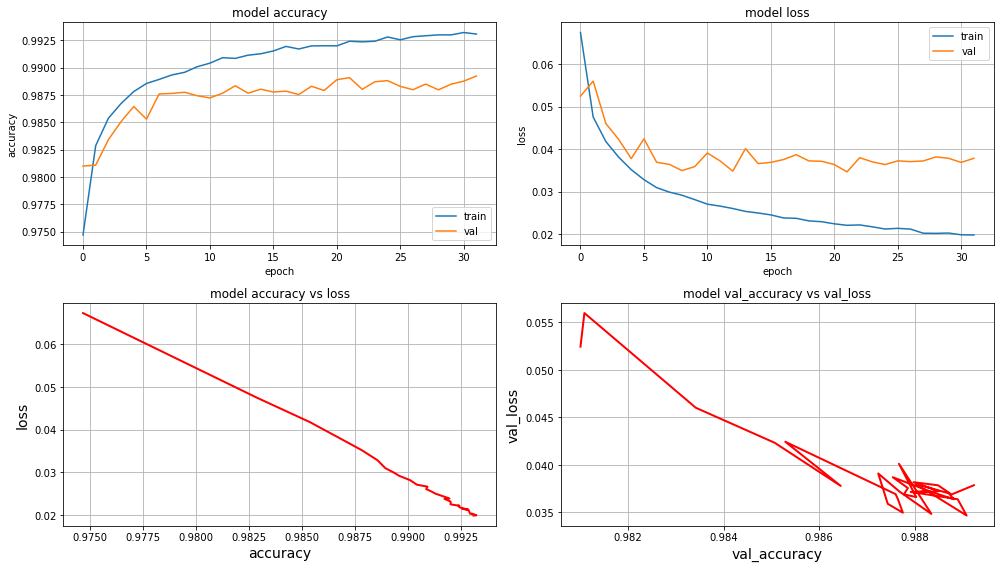

[2020-09-09/20:32:06.809|14.3%|65.9%|1.89GB] ========== FOLD 2 ==========


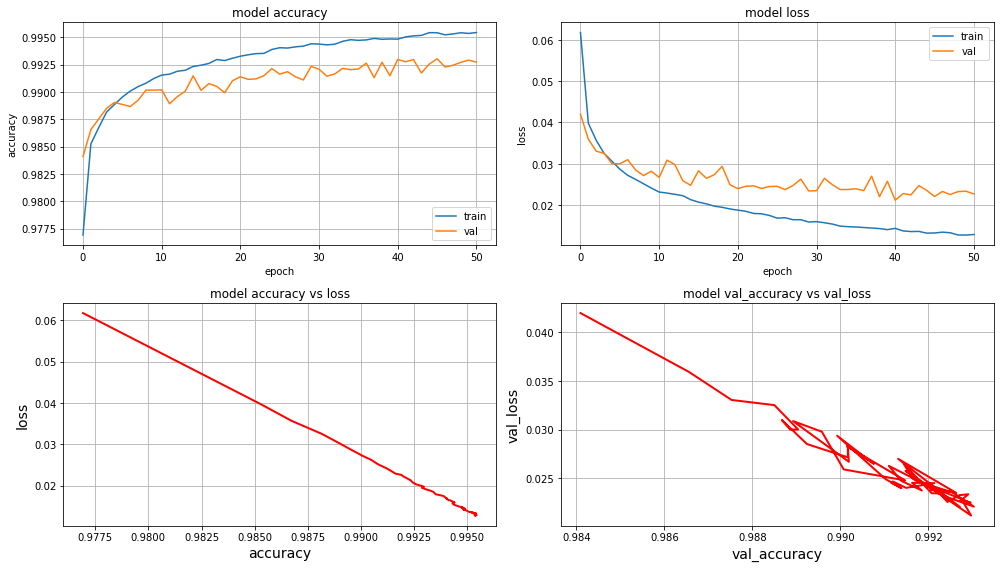

[2020-09-09/20:32:08.161|13.8%|66.2%|1.90GB] ========== FOLD 3 ==========


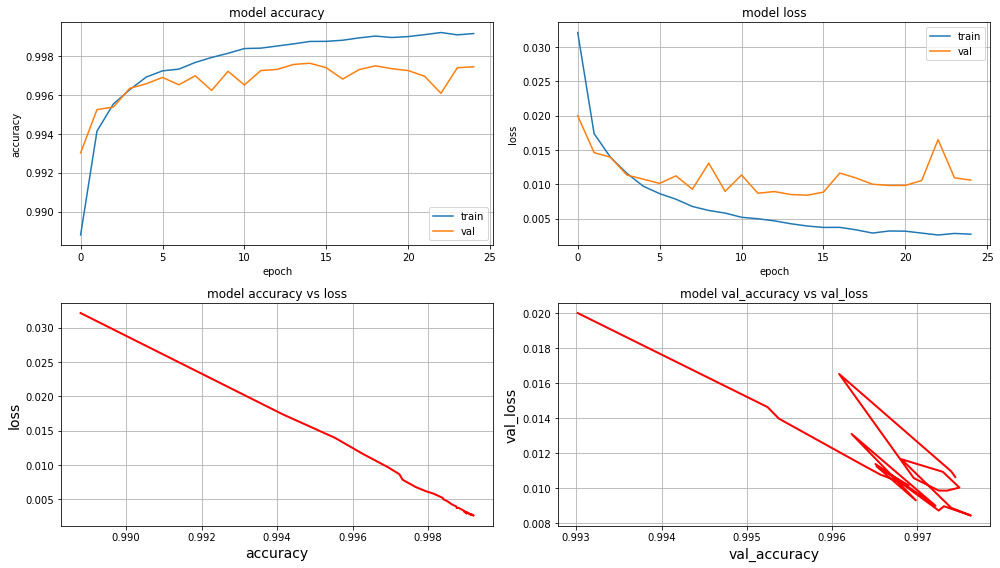

[2020-09-09/20:32:09.453|13.2%|66.2%|1.90GB] ========== FOLD 4 ==========


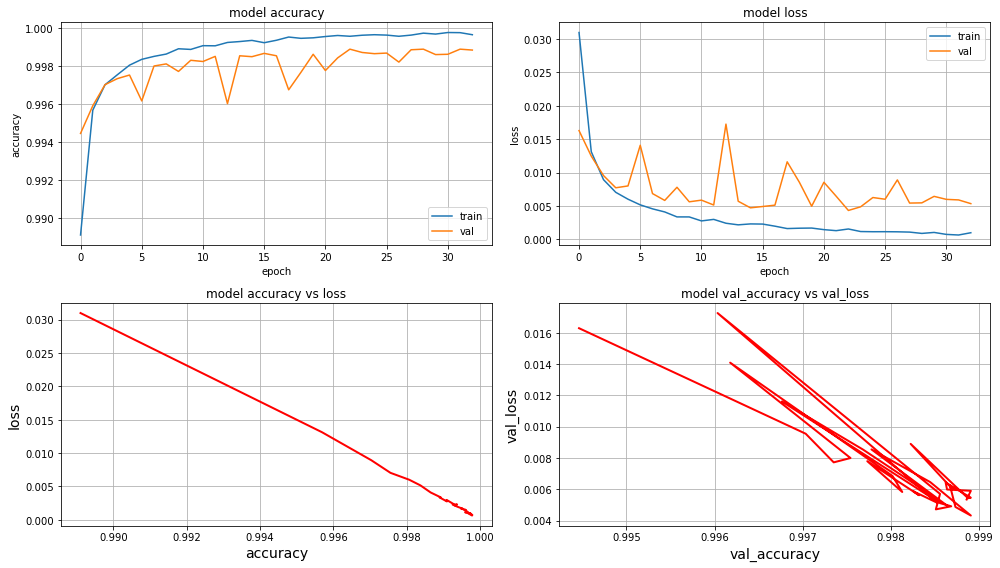

In [5]:
from audace.plotters import plot_nn_learning_curves

for i, fold in enumerate(ds.listAttributeValues(FOLD_NAME)):
    iprint(F"========== FOLD {fold} ==========")
    plot_nn_learning_curves(histories[i], EXP_NAME, 'learning report fold ' + str(fold))

<hr style="border:1px solid gray"></hr>

### Step 4 : Display performance reports

[2020-09-09/20:32:10.905|13.9%|66.3%|1.91GB] ========== FOLD 1 ==========


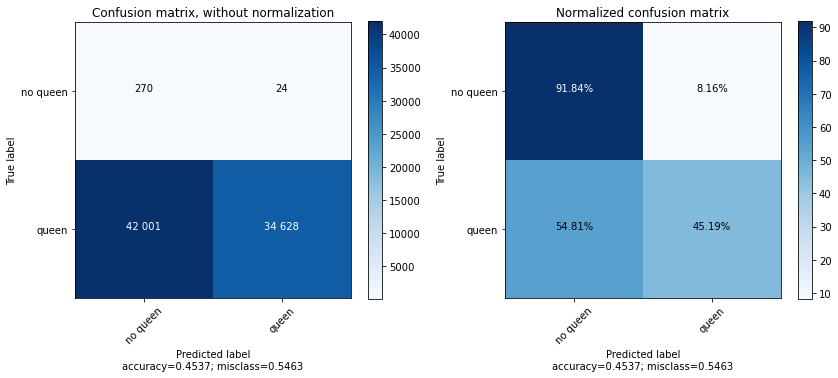

[2020-09-09/20:32:12.833|25.0%|69.6%|2.16GB] >>>>> Predict
[2020-09-09/20:32:14.498|21.2%|68.6%|2.17GB] loss: 4.474479446023659
[2020-09-09/20:32:14.498|00.0%|68.6%|2.17GB] accuracy: 0.45367446541786194
[2020-09-09/20:32:16.339|19.4%|68.5%|2.17GB] ans: 1.0 / acc: 0.4536744536744537
[2020-09-09/20:32:16.339|00.0%|68.5%|2.17GB] ========== FOLD 2 ==========


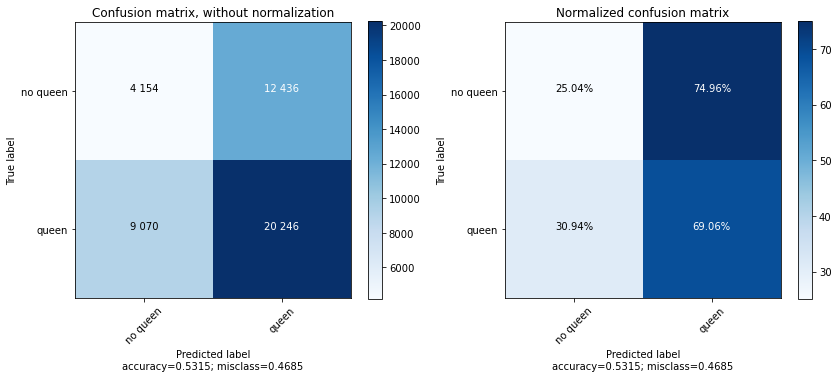

[2020-09-09/20:32:17.549|20.7%|70.5%|2.32GB] >>>>> Predict
[2020-09-09/20:32:18.554|18.4%|70.5%|2.32GB] loss: 3.907850746391116
[2020-09-09/20:32:18.555|00.0%|70.5%|2.32GB] accuracy: 0.5315209627151489
[2020-09-09/20:32:19.660|17.9%|70.5%|2.32GB] ans: 1.0 / acc: 0.5315209340826907
[2020-09-09/20:32:19.661|00.0%|70.5%|2.32GB] ========== FOLD 3 ==========


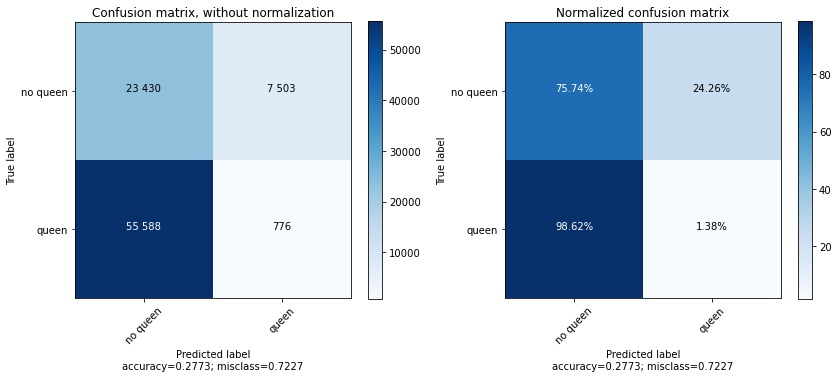

[2020-09-09/20:32:21.594|21.8%|70.6%|2.61GB] >>>>> Predict
[2020-09-09/20:32:23.480|21.9%|70.6%|2.61GB] loss: 33.55590593733458
[2020-09-09/20:32:23.481|00.0%|70.6%|2.61GB] accuracy: 0.27728331089019775
[2020-09-09/20:32:25.372|18.0%|70.6%|2.61GB] ans: 1.0 / acc: 0.27728329724961914
[2020-09-09/20:32:25.372|00.0%|70.6%|2.61GB] ========== FOLD 4 ==========


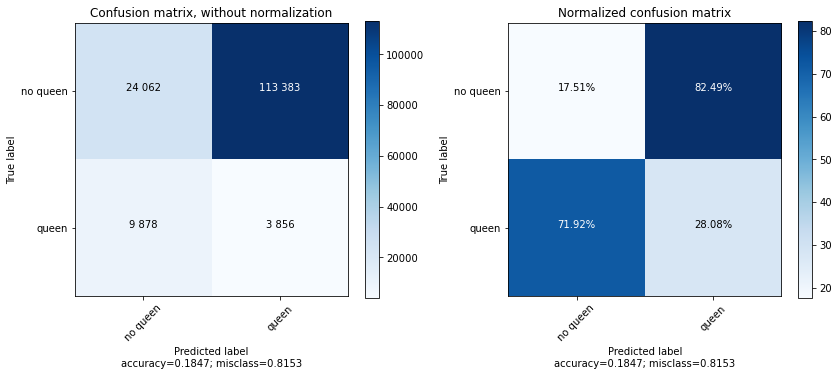

[2020-09-09/20:32:28.667|18.5%|70.6%|2.61GB] >>>>> Predict
[2020-09-09/20:32:31.790|21.4%|70.6%|2.61GB] loss: 23.276077472381484
[2020-09-09/20:32:31.791|00.0%|70.6%|2.61GB] accuracy: 0.18466851115226746
[2020-09-09/20:32:35.307|17.4%|70.6%|2.61GB] ans: 1.0 / acc: 0.18466850554640526


In [6]:
from audace.plotters import nn_full_report
from audace.metrics import i_may_be_wrong

for i, fold in enumerate(ds.listAttributeValues(FOLD_NAME)):
    iprint(F"========== FOLD {fold} ==========")
    nn_full_report(models[i], X_tests[i], y_tests[i], target_names = ['no queen', 'queen'])

    #Predict the response for test dataset
    iprint('>>>>> Predict')
    scores = models[i].evaluate(X_tests[i], y_tests[i], verbose=0)

    for j in range(len(scores)):
        iprint(F"{models[i].metrics_names[j]}: {scores[j]}")
        
        
    ans, acc = i_may_be_wrong(models[i], X_tests[i], y_tests[i], 0.01, 0.99)
    iprint(F"ans: {ans} / acc: {acc}")